In [1]:
from pythtb_Wannier import *
from pythtb import *
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sympy as sp 
import scipy

In [2]:
delta = 1
t0 = 0.1
tprime = 0.5

model = models.chessboard(t0, tprime, delta).make_supercell([[2,0], [0,2]])

orbs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)
lat_vecs = model.get_lat() # lattice vectors

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)

# adding disorder
# J = 2
# J_site = 2
# model.set_onsite(J, ind_i = J_site, mode='add')

# model.display()

In [3]:
# 2D k-mesh
nkx = 20
nky = 20
Nk = nkx*nky

k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)
k_mesh_flat = gen_k_mesh(nkx, nky, flat=True, endpoint=False)

In [4]:
u_wfs_full = wf_array(model, [nkx, nky])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print("Chern number: ", chern)

Chern number:  -3.975693351829396e-17


In [5]:
u_wfs_Wan = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs_Wan.solve_on_one_point(k_mesh[i,j], [i,j])

In [6]:
omit = False
omit_site = 4
compact_SVD = False

if omit:
    tf_list = list(np.setdiff1d(low_E_sites, [omit_site])) # delta on lower energy sites omitting the last site
else:
    tf_list = list(low_E_sites[:]) # delta on lower energy sites

n_tfs = len(tf_list)

In [7]:
w0 = Wannierize(
    model, u_wfs_Wan, tf_list, compact_SVD=compact_SVD
    )

In [8]:
u_wfs = np.array(u_wfs_Wan._wfs)
psi_wfs = get_bloch_wfs(model, u_wfs_Wan, k_mesh_flat)
psi_tilde = get_psi_tilde(psi_wfs, tf_list)
u_tilde = get_bloch_wfs(model, psi_tilde, k_mesh_flat, inverse=True)

tfs = set_trial_function(tf_list, n_orb)
state_idx = list(range(0, int(n_orb/2))) # assuming we are Wannierizing occupied bands (half filled)
A = tf_overlap_mat(psi_wfs, tfs, state_idx)
V, S, Wh = SVD(A, full_matrices=False, compact_SVD=compact_SVD)

$P_{\mathbf{k}}  =  \sum_{n} |\psi_{n,\mathbf{k}}\rangle \langle \psi_{n,\mathbf{k}}|$

In [9]:
P_k = np.array([[
    np.sum( [np.outer(psi_wfs[kx, ky, n, :].T, psi_wfs[kx, ky, n, :].conj()) for n in range(int(n_occ))], axis=0)
    for ky in range(nky)] for kx in range(nkx)]) 

Q_k = np.array([[ np.eye(P_k[kx,ky].shape[0]) - P_k[kx,ky] for ky in range(nky)] for kx in range(nkx)])

$P_{\mathbf{k}}^{(u)}  =  \sum_{n} |u_{n,\mathbf{k}}\rangle \langle u_{n,\mathbf{k}}|$

In [10]:
P_uk = np.array([[
    np.sum( [np.outer(u_wfs[kx, ky, n, :].T, u_wfs[kx, ky, n, :].conj()) for n in range(int(n_occ))], axis=0)
    for ky in range(nky)] for kx in range(nkx)]) 

Q_uk = np.array([[ np.eye(P_k[kx,ky].shape[0]) - P_k[kx,ky] for ky in range(nky)] for kx in range(nkx)])

$\tilde{P}_{\mathbf{k}}  =  \sum_{n} |\tilde{\psi}_{n,\mathbf{k}}\rangle \langle \tilde{\psi}_{n,\mathbf{k}}|$

In [11]:
Pk_til = np.array([[
    np.sum( [np.outer(psi_tilde[kx, ky, n, :].T, psi_tilde[kx, ky, n, :].conj()) for n in range(int(n_tfs))], axis=0)
    for ky in range(nky)] for kx in range(nkx)]) 

Qk_til = np.array([[ np.eye(Pk_til[kx,ky].shape[0]) - Pk_til[kx,ky] for ky in range(nky)] for kx in range(nkx)])

$\tilde{P}_{\mathbf{k}}^{(u)} =  \sum_{n} |\tilde{u}_{n,\mathbf{k}}\rangle \langle \tilde{u}_{n,\mathbf{k}}|$

In [12]:
Pk_util = np.array([[
    np.sum( [np.outer(u_tilde[kx, ky, n, :].T, u_tilde[kx, ky, n, :].conj()) for n in range(int(n_tfs))], axis=0)
    for ky in range(nky)] for kx in range(nkx)]) 

Qk_util = np.array([[ np.eye(Pk_util[kx,ky].shape[0]) - Pk_util[kx,ky] for ky in range(nky)] for kx in range(nkx)])

In [13]:
nks = nkx, nky
k_vals = [range(nk) for nk in nks]
k_idx_arr = list(product(*k_vals))

Pk_util2 = np.zeros((*nks, n_orb, n_orb), dtype=complex)
Qk_util2 = np.zeros((*nks, n_orb, n_orb), dtype=complex)

for k in k_idx_arr:
    Pk_util2[k][:, :] = np.sum([np.outer(u_tilde[k][n, :], u_tilde[k][n, :].conj() ) for n in range(int(n_tfs))], axis=0)
    Qk_util2[k][:, :] = np.eye(Pk_util2[k].shape[0]) - Pk_util2[k]

print(np.allclose(Pk_util, Pk_util2))
print(np.allclose(Qk_util, Qk_util2))

True
True


$P_{\mathbf{R}} = \sum_n |w_{\mathbf{R}, n}\rangle \langle w_{\mathbf{R}, n}|$

In [14]:
P_R = np.array([[
    np.sum( [np.outer(w0[rx, ry, n, :].T, w0[rx, ry, n, :].conj()) for n in range(int(n_tfs))], axis=0)
    for ry in range(nky)] for rx in range(nkx)]) 

Q_R = np.array([[ np.eye(P_R[rx,ry].shape[0]) - P_R[rx,ry] for ry in range(nky)] for rx in range(nkx)])

Is $\sum_{\mathbf{k}} \tilde{P}_{\mathbf{k}} = \sum_{\mathbf{k}} P_{\mathbf{k}} = N \sum_{\mathbf{R}} P_{\mathbf{R}} $?

In [15]:
P_Bloch = np.sum(P_k, axis=(0,1))
P_Tilde = np.sum(Pk_til, axis=(0,1))
P_Wan = Nk*np.sum(P_R, axis=(0,1))
Pu_Tilde = np.sum(Pk_util, axis=(0,1))
Pu_Bloch = np.sum(P_uk, axis=(0,1))

print(np.allclose(P_Bloch, P_Tilde))
print(np.allclose(P_Bloch, P_Wan))
print(np.allclose(P_Tilde, P_Wan))
print(np.allclose(P_Tilde, Pu_Tilde))
print(np.allclose(Pu_Bloch, Pu_Tilde))

True
True
True
False
True


$$||P_{Wan} - P_{Bloch}||_F $$

In [16]:
diff = P_Bloch - P_Wan
# sp.Matrix(diff.round(5))

rel_dist = np.linalg.norm(diff)/np.sqrt((np.linalg.norm(P_Bloch)**2 + np.linalg.norm(P_Wan)**2))
rel_dist

1.0445243830328602e-15

## Minimization of $\Omega_I$

In [17]:
# 2D k-mesh
num_NN = 4 # number of nearest neighbors in reciprocal lattice
G = 2*np.pi/lat_vecs[0][0] # reciprocal lattice vector
b = G / nkx  # spacing between allowed kx
w_b = 1/(2*b**2) # finite difference weights for cubic lattice

b_vec = [np.array([b, 0]), np.array([0, b]), np.array([-b, 0]), np.array([0, -b])] # vectors connecting nearest neighbor k points
b_idx = np.array(np.array(b_vec)/b, dtype=int) # index translation array 

Is it true that $$T_{k,b} = N_{occ} - \sum_{m,n} |M_{mn}^{(k,b)}|^2 = \text{Tr}[\hat{P}_{k}\hat{Q}_{k+b}]$$

In [18]:
# 2D k-mesh
num_NN = 4 # number of nearest neighbors in reciprocal lattice
G = 2*np.pi/lat_vecs[0][0] # reciprocal lattice vector
b = G / nkx  # spacing between allowed kx
w_b = 1/(2*b**2) # finite difference weights for cubic lattice

# b_vec = [np.array([b, 0]), np.array([0, b]), np.array([-b, 0]), np.array([0, -b])] # vectors connecting nearest neighbor k points
nnbr_mask = list(product([-1, 0, 1], repeat=2))
b_idx = np.array([nnbr_vec for nnbr_vec in nnbr_mask if sum(abs(nnbr) for nnbr in nnbr_vec) == 1], dtype=int) # index translation array 

In [19]:
nks = nkx, nky
k_vals = [range(nk) for nk in nks]
k_idx_arr = list(product(*k_vals))

Pk_util_b = np.zeros((*nks, num_NN, n_orb, n_orb), dtype=complex)
Qk_util_b = np.zeros((*nks, num_NN, n_orb, n_orb), dtype=complex)

for k in k_idx_arr:
    for idx, t_k in enumerate(b_idx):
        k_nbr_idx = tuple(np.array(k) + t_k)

        # assumes first and last indices are at edge of BZ
        bc_phase = np.array(np.exp(-1j*2*np.pi*orbs @ t_k.T ), dtype=complex).T if np.any(np.in1d(k_nbr_idx, [-1, *nks])) else 1
        # print(k, t_k, k_nbr_idx, k_mesh[k], k_mesh[k_nbr_idx], bc_phase)

        # apply pbc
        k_nbr_idx = np.mod(k_nbr_idx, nks)
        state = u_tilde[tuple(k_nbr_idx)] * bc_phase
        
        Pk_util_b[k][idx, :, :] = np.sum( [np.outer(state[n].T, state[n].conj()) for n in range(int(n_tfs))], axis=0)
        Qk_util_b[k][idx, :, :] = np.eye(n_orb) - Pk_util_b[k][idx, :, :] 

In [20]:
nks = nkx, nky
k_vals = [range(nk) for nk in nks]
k_idx_arr = list(product(*k_vals))

Pk_util_b = np.zeros((*nks, num_NN, n_orb, n_orb), dtype=complex)
Qk_util_b = np.zeros((*nks, num_NN, n_orb, n_orb), dtype=complex)

for k in k_idx_arr:
    for idx, t_k in enumerate(b_idx):
        k_nbr = np.array(k) + t_k
        bc_phase = np.array(np.exp(-1j*2*np.pi*orbs @ t_k.T ), dtype=complex).T if np.any(np.in1d(k_nbr, [-1, *nks])) else 1

        # apply pbc
        k_nbr = np.mod(k_nbr, nks)
        state = u_tilde[tuple(k_nbr)] * bc_phase
        
        Pk_util_b[k][idx, :, :] = np.sum( [np.outer(state[n].T, state[n].conj()) for n in range(int(n_tfs))], axis=0)
        Qk_util_b[k][idx, :, :] = np.eye(n_orb) - Pk_util_b[k][idx, :, :] 

In [21]:
Omega_I = 0

for kx in range(nkx):
    for ky in range(nky):
        for idx, t_k in enumerate(b_idx):
            T_kb = np.trace(Pk_util[kx, ky] @ Qk_util_b[kx, ky, idx])
            # assert np.isclose(
            #     n_occ - np.sum(abs(M[kx, ky, idx])**2, axis=(0,1)), T_kb,
            #     )
            Omega_I += (1/Nk) * w_b * T_kb

print(f"Omega_I from Tr(P_k Q_k+b): {Omega_I}")

Omega_I from Tr(P_k Q_k+b): (0.29600877975528456-5.338600136912201e-18j)


In [22]:
M = k_overlap_mat(u_tilde, num_NN, orbs=orbs) # [kx, ky, b, m, n]
spread, expc_rsq, expc_r_sq = spread_recip(M, w_b, b_vec, decomp=True)
print(rf"Omega_I from M_kb = {spread[1]}")
print(rf"Omega_tilde from M_kb = {spread[2]}")

Omega_I from M_kb = 0.2960087797552824
Omega_tilde from M_kb = (0.028601848003985263+0j)


Iterative procedure

In [23]:
nks = nkx, nky
k_vals = [range(nk) for nk in nks]
k_idx_arr = list(product(*k_vals))

Pk_util_min = np.copy(Pk_util)
Pk_util_min_b = np.copy(Pk_util_b) # start of iteration
Qk_util_min_b = np.copy(Qk_util_b) # start of iteration
u_til_min = np.zeros((*nks, n_tfs, n_orb), dtype=complex)
n_occ = int(n_orb/2)

tol = 2e-4
diff = None

for i in range(100):
    for k in k_idx_arr:
        P_avg = np.zeros((n_orb, n_orb), dtype=complex)

        for idx, t_k in enumerate(b_idx):
            P_avg += w_b * Pk_util_min_b[k][idx, :, : ]
        
        # change of basis
        Z = np.zeros((n_occ, n_occ), dtype=complex)
        for n in range(n_occ):
            for m in range(n_occ):
                Z[m, n] = u_wfs[k][m, :].conj() @ (P_avg @ u_wfs[k][n, :])
        
        eigvals, eigvecs = np.linalg.eigh(Z) # [val, idx]
        
        for idx, n in enumerate(np.argsort(eigvals.real)[-n_tfs:]): # keep ntfs wfs with highest eigenvalue
            u_til_min[k][idx, :] = sum([eigvecs[i, n] * u_wfs[k][i, :] for i in range(eigvecs.shape[0])])

        P_new = np.sum( [np.outer(u_til_min[k][n, :], u_til_min[k][n, :].conj()) for n in range(n_tfs)], axis=0)
        diff = (np.linalg.norm(Pk_util_min[k] - P_new)
                /np.sqrt((np.linalg.norm(Pk_util_min[k])**2 + np.linalg.norm(P_new)**2)))
        # print(diff)
        
        Pk_util_min[k] = 0.5 * P_new + 0.5 * Pk_util_min[k]# for next iteration
        
        for idx, t_k in enumerate(b_idx):
            k_nbr = np.array(k) + t_k
            bc_phase = np.array(np.exp(-1j*2*np.pi*orbs @ t_k.T ), dtype=complex).T if np.any(np.in1d(k_nbr, [-1, *nks])) else 1

            # apply pbc
            k_nbr = np.mod(k_nbr, nks)
            state_pbc = u_til_min[tuple(k_nbr)] * bc_phase
            
            Pk_util_min_b[k][idx, :, :] = np.sum( [np.outer(state_pbc[n].T, state_pbc[n].conj()) for n in range(int(n_tfs))], axis=0)
            Qk_util_min_b[k][idx, :, :] = np.eye(n_orb) - Pk_util_min_b[k][idx, :, :] 

In [24]:
Omega_I = 0

for kx in range(nkx):
    for ky in range(nky):
        for idx, t_k in enumerate(b_idx):
            T_kb = np.trace(Pk_util_min[kx, ky] @ Qk_util_min_b[kx, ky, idx])
            Omega_I += (1/Nk) * w_b * T_kb

print(f"Omega_I from Tr(P_k Q_k+b): {Omega_I}")

Omega_I from Tr(P_k Q_k+b): (0.29600877975532164-1.0739475175835705e-17j)


In [25]:
Pu_Tilde_min = np.sum(Pk_util_min, axis=(0,1))

In [26]:
diff = Pu_Tilde_min - Pu_Tilde
rel_dist = np.linalg.norm(diff)/np.sqrt((np.linalg.norm(Pu_Tilde_min)**2 + np.linalg.norm(Pu_Tilde)**2))
rel_dist

1.133121458746582e-16

In [27]:
psi_til_min = get_bloch_wfs(model, u_til_min, k_mesh_flat)

Pk_til_min = np.array([[
    np.sum( [np.outer(psi_til_min[kx, ky, n, :].T, psi_til_min[kx, ky, n, :].conj()) for n in range(int(n_tfs))], axis=0)
    for ky in range(nky)] for kx in range(nkx)]) 

In [28]:
outer_states = u_wfs[..., :n_occ, :]
util_min = find_optimal_subspace(model, outer_states, u_tilde, iter_num=100, tol=2e-4)

In [29]:
M = k_overlap_mat(u_til_min, num_NN, orbs=orbs) # [kx, ky, b, m, n]
spread, expc_rsq, expc_r_sq = spread_recip(M, w_b, b_vec, decomp=True)
print(rf"Omega_til from M_kb = {spread[0]}")
print(rf"Omega_I from M_kb = {spread[1]}")

Omega_til from M_kb = (1352.6179373323303+0j)
Omega_I from M_kb = 0.2960087797553611


In [30]:
print(np.allclose(np.sum(Pk_til_min, axis=(0,1)), np.sum(Pk_til, axis=(0,1))))

True


In [31]:
state_idx = list(range(0, psi_til_min.shape[2]))
psi_til_til_min = get_psi_tilde(psi_til_min, tf_list, state_idx=state_idx)

w0 = DFT(psi_til_til_min)

In [32]:
# spread, expc_rsq, expc_r_sq = spread_real(w0, orbs, lat_vecs, decomp=True)
# print(rf"Omega_I from w0= {spread[1]}")
# print(rf"Omega_tilde from w0 = {spread[2]}")

In [33]:
u_til_til_min = get_bloch_wfs(model, psi_til_til_min, k_mesh_flat, inverse=True)

M = k_overlap_mat(u_til_til_min, num_NN, orbs=orbs) # [kx, ky, b, m, n]
spread, expc_rsq, expc_r_sq = spread_recip(M, w_b, b_vec, decomp=True)
print(rf"Omega_I from M_kb = {spread[1]}")
print(rf"Omega_tilde from M_kb = {spread[2]}")

Omega_I from M_kb = 0.29600877975536366
Omega_tilde from M_kb = (0.028601848003985266+0j)


([<Figure size 640x480 with 2 Axes>, <Figure size 640x480 with 1 Axes>],
 [<Axes: >, <Axes: xlabel='$|\\mathbf{r}|$', ylabel='$|w_0(\\mathbf{r})|^2$'>])

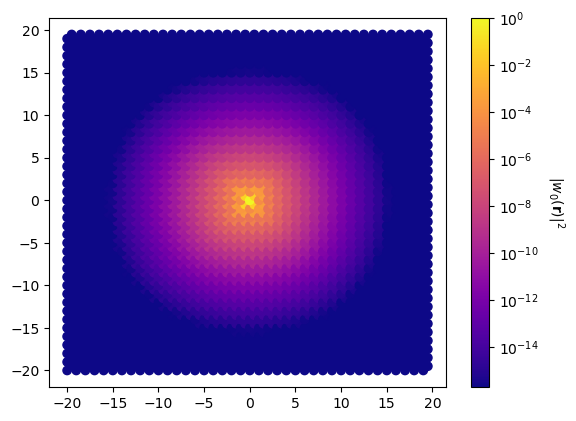

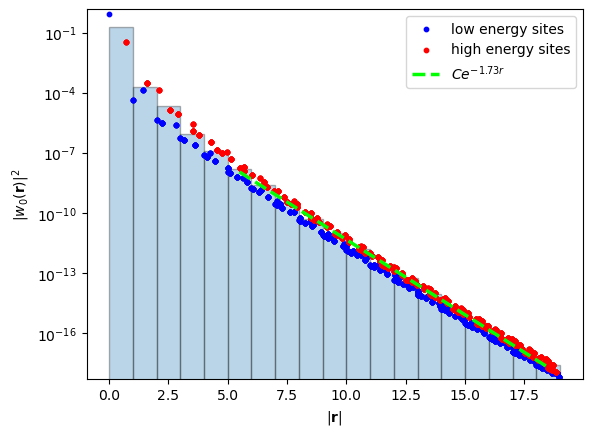

In [34]:
plot.plot_Wan(w0, 0, orbs, lat_vecs, plot_decay=True)